In [9]:
!wget -O brain_tumor_dataset.zip https://figshare.com/ndownloader/articles/1512427/versions/5

--2022-08-30 20:19:42--  https://figshare.com/ndownloader/articles/1512427/versions/5
Resolving figshare.com (figshare.com)... 52.30.212.171, 54.216.129.95, 2a05:d018:1f4:d000:62ff:49cf:ea81:66f4, ...
Connecting to figshare.com (figshare.com)|52.30.212.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879501695 (839M) [application/zip]
Saving to: ‘brain_tumor_dataset.zip’

brain_tumor_dataset 100%[===================>] 838.76M  55.2MB/s    in 11s     

2022-08-30 20:19:54 (73.4 MB/s) - ‘brain_tumor_dataset.zip’ saved [879501695/879501695]



In [10]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/sinamhd9/chexnet-weights")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kaledhoshme
Your Kaggle Key: ··········


100%|██████████| 25.4M/25.4M [00:00<00:00, 32.9MB/s]


In [12]:
!unzip brain_tumor_dataset.zip

Archive:  brain_tumor_dataset.zip
 extracting: brainTumorDataPublic_1-766.zip  
 extracting: brainTumorDataPublic_1533-2298.zip  
 extracting: brainTumorDataPublic_767-1532.zip  
 extracting: brainTumorDataPublic_2299-3064.zip  
 extracting: cvind.mat               
 extracting: README.txt              


In [13]:
!mkdir brain_tumor_dataset

In [14]:
!unzip brainTumorDataPublic_1-766.zip -d brain_tumor_dataset
!unzip brainTumorDataPublic_1533-2298.zip -d brain_tumor_dataset
!unzip brainTumorDataPublic_767-1532.zip -d brain_tumor_dataset
!unzip brainTumorDataPublic_2299-3064.zip -d brain_tumor_dataset

Archive:  brainTumorDataPublic_1-766.zip
  inflating: brain_tumor_dataset/1.mat  
  inflating: brain_tumor_dataset/10.mat  
  inflating: brain_tumor_dataset/100.mat  
  inflating: brain_tumor_dataset/101.mat  
  inflating: brain_tumor_dataset/102.mat  
  inflating: brain_tumor_dataset/103.mat  
  inflating: brain_tumor_dataset/104.mat  
  inflating: brain_tumor_dataset/105.mat  
  inflating: brain_tumor_dataset/106.mat  
  inflating: brain_tumor_dataset/107.mat  
  inflating: brain_tumor_dataset/108.mat  
  inflating: brain_tumor_dataset/109.mat  
  inflating: brain_tumor_dataset/11.mat  
  inflating: brain_tumor_dataset/110.mat  
  inflating: brain_tumor_dataset/111.mat  
  inflating: brain_tumor_dataset/112.mat  
  inflating: brain_tumor_dataset/113.mat  
  inflating: brain_tumor_dataset/114.mat  
  inflating: brain_tumor_dataset/115.mat  
  inflating: brain_tumor_dataset/116.mat  
  inflating: brain_tumor_dataset/117.mat  
  inflating: brain_tumor_dataset/118.mat  
  inflating: brai

In [15]:
!pip install pymatreader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from pymatreader import read_mat
import cv2
from sklearn.model_selection import train_test_split
from keras.applications import densenet
from keras.initializers import GlorotNormal

In [2]:
class Brain_Tumor:
  def __init__(self, epochs, 
               batch_size, 
               dataset_folder,
               optimizer,
               loss):
    self.epochs = epochs
    self.batch_size = batch_size
    self.dataset_folder = dataset_folder
    self.optimizer = optimizer
    self.loss = loss
    self.DatasetFiles = list(pathlib.Path(os.path.join(self.dataset_folder)).glob("*.*"))
    self.classes = ["meningioma", "glioma","pituitary"]
  def read_mat_file(self, 
                    single_file):
    return read_mat(os.path.join(single_file))
  def plot_some_dataset_images(self,
                               number_of_image):
    plt.figure(figsize = (20, 8))
    for i in range(number_of_image):
      mat_obj = self.read_mat_file(self.DatasetFiles[i])
      plt.subplot(2, 4, i + 1)
      img = mat_obj['cjdata']['image']
      label = int(mat_obj['cjdata']['label'])
      plt.imshow(img)
      plt.title(self.classes[label - 1])
    plt.show()
  def collect_features_labels(self):
    images = []
    labels = []
    for single_file in self.DatasetFiles:
      mat_obj = self.read_mat_file(single_file)
      img = mat_obj['cjdata']['image']
      img = img/255
      img = np.float32(img)
      img = cv2.resize(img, (224, 224))
      img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
      img = img - np.mean(img)
      img = img/np.std(img)
      lab = int(mat_obj['cjdata']['label'])
      images.append(img)
      labels.append(lab)
    self.images = np.asarray(images)
    self.labels = np.asarray(labels)
  def DataAugmentation_Object(self):
    return tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=0.2,
        zoom_range=0.01,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=None)
  def augmentated_images(self):
    images_after_aug = []
    labels_after_aug = []
    augmentation_object = self.DataAugmentation_Object()
    for index, image in enumerate(self.images):
      for i in range(3):
          img = augmentation_object.flow(np.reshape(image, (1, 224, 224, 3))).next()
          images_after_aug.append(np.reshape(img, (224, 224, 3)))
          labels_after_aug.append(self.labels[index])
    self.labels = np.asarray(labels_after_aug)
    self.images = np.asarray(images_after_aug)
  def to_categorical_label(self):
    self.labels = self.labels - 1
    self.labels = tf.keras.utils.to_categorical(self.labels, num_classes = 3)
  def train_test_split(self, test_size):
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.images, 
                                                        self.labels, 
                                                        random_state = 42, 
                                                        test_size = test_size)
  def Model(self):
    d = densenet.DenseNet121(weights=None, include_top = False, input_shape = (224, 224, 3))
    m = tf.keras.layers.Dropout(0.8)(d.output)
    m = tf.keras.layers.GlobalAveragePooling2D(name = "GlobalAveragePooling2D_")(m)                         
    m = tf.keras.layers.Dropout(0.8)(m)
    m = tf.keras.layers.Dense(3, kernel_initializer=GlorotNormal(),
                              activation = 'softmax', kernel_regularizer= tf.keras.regularizers.L2(0.0001),
                              bias_regularizer= tf.keras.regularizers.L2(0.0001))(m)
    m = tf.keras.models.Model(inputs = d.input, outputs = m)
    m.load_weights("chexnet-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5", by_name=True, skip_mismatch=True)
    for layer in m.layers[:200]:
        layer.trainable = False
    for layer in m.layers[200:]:
        layer.trainable = True
    self.m = m
  def compile(self):
    self.m.compile(optimizer = self.optimizer
          , loss = self.loss, metrics = ['accuracy'])
  def fit_model(self):
    self.history = self.m.fit(self.X_train, self.y_train, epochs = self.epochs, batch_size = self.batch_size,
                validation_data = (self.X_test, self.y_test),
                callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, mode = 'min',
                                                  patience= 2),
                             tf.keras.callbacks.EarlyStopping(patience = 14, monitor = 'val_loss', mode = 'min', restore_best_weights=True)])                       

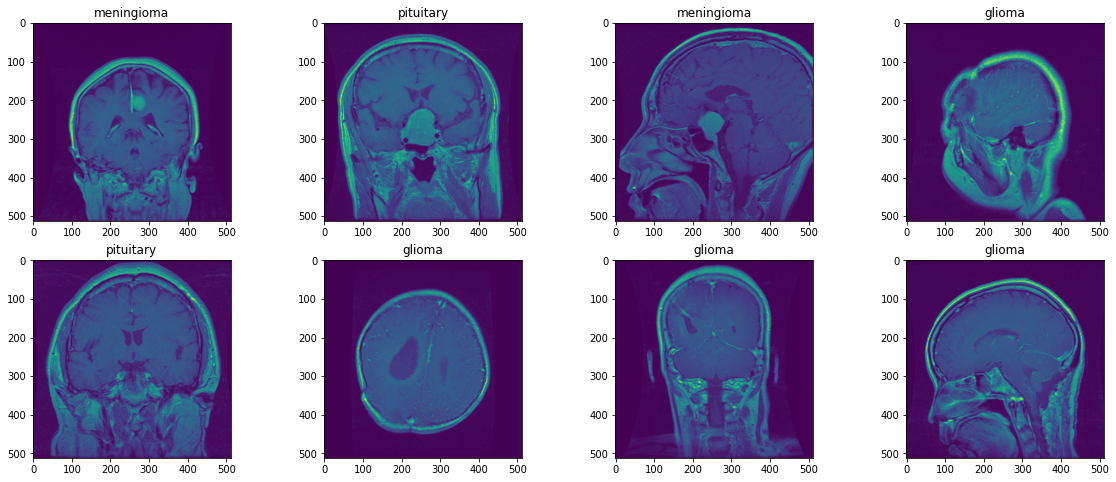

In [3]:
Brain_Tumor_obj = Brain_Tumor(25, 
                              2, 
                              'brain_tumor_dataset', 
                              tf.keras.optimizers.Adam(0.001), 
                              'categorical_crossentropy')
Brain_Tumor_obj.plot_some_dataset_images(8)

In [4]:
Brain_Tumor_obj.collect_features_labels()

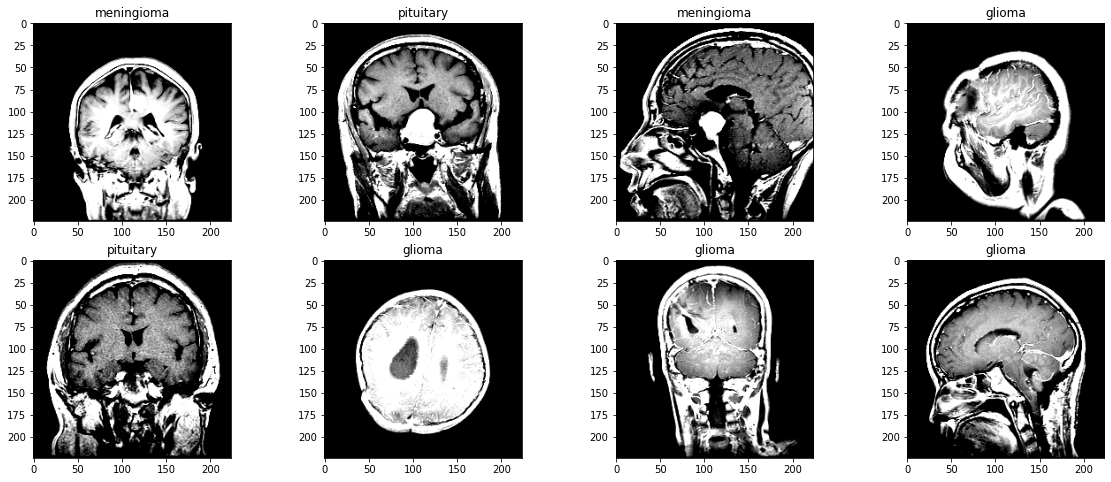

In [5]:
plt.figure(figsize = (20, 8))
for i in range(8):
  plt.subplot(2, 4, i+ 1)
  plt.imshow(Brain_Tumor_obj.images[i])
  plt.title(Brain_Tumor_obj.classes[Brain_Tumor_obj.labels[i] - 1])
plt.show()

In [6]:
Brain_Tumor_obj.augmentated_images()

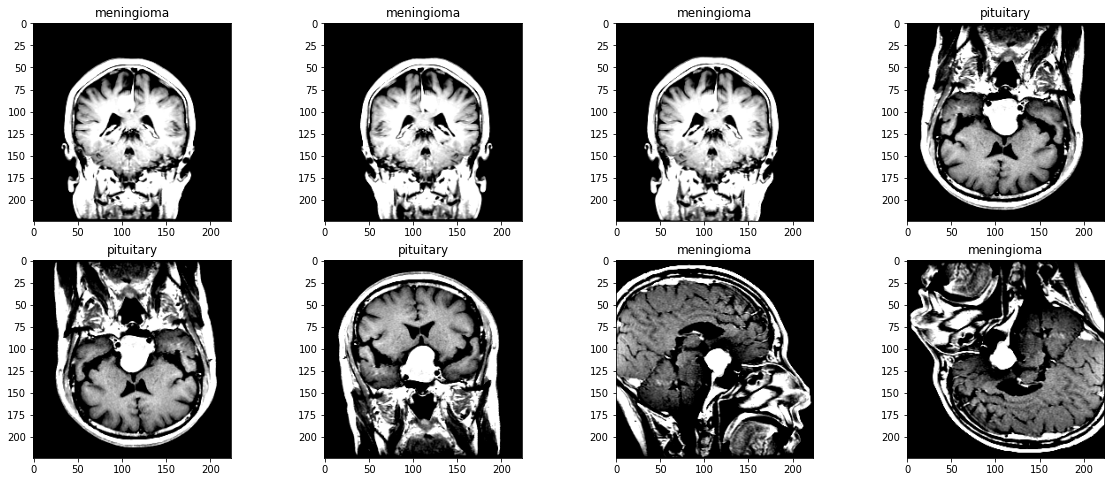

In [7]:
plt.figure(figsize = (20, 8))
for i in range(8):
  plt.subplot(2, 4, i + 1)
  plt.imshow(Brain_Tumor_obj.images[i])
  plt.title(Brain_Tumor_obj.classes[Brain_Tumor_obj.labels[i] - 1])
plt.show()

In [8]:
Brain_Tumor_obj.to_categorical_label()

In [9]:
Brain_Tumor_obj.train_test_split(0.1)

In [10]:
Brain_Tumor_obj.Model()
Brain_Tumor_obj.compile()
Brain_Tumor_obj.fit_model()

Epoch 1/25
4136/4136 [==============================] - 171s 36ms/step - loss: 0.9056 - accuracy: 0.6246 - val_loss: 0.3227 - val_accuracy: 0.8598 - lr: 0.0010
Epoch 2/25
4136/4136 [==============================] - 145s 35ms/step - loss: 0.5004 - accuracy: 0.8096 - val_loss: 0.2126 - val_accuracy: 0.9304 - lr: 0.0010
Epoch 3/25
4136/4136 [==============================] - 145s 35ms/step - loss: 0.3409 - accuracy: 0.8744 - val_loss: 0.1842 - val_accuracy: 0.9435 - lr: 0.0010
Epoch 4/25
4136/4136 [==============================] - 144s 35ms/step - loss: 0.2473 - accuracy: 0.9119 - val_loss: 0.1805 - val_accuracy: 0.9293 - lr: 0.0010
Epoch 5/25
4136/4136 [==============================] - 145s 35ms/step - loss: 0.2018 - accuracy: 0.9322 - val_loss: 0.1252 - val_accuracy: 0.9587 - lr: 0.0010
Epoch 6/25
4136/4136 [==============================] - 148s 36ms/step - loss: 0.1730 - accuracy: 0.9419 - val_loss: 0.1378 - val_accuracy: 0.9457 - lr: 0.0010
Epoch 7/25
4136/4136 [==================

In [24]:
Brain_Tumor_obj.m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

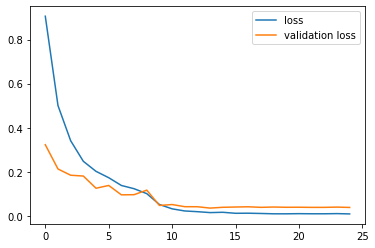

In [11]:
plt.plot(Brain_Tumor_obj.history.history['loss'], label = "loss")
plt.plot(Brain_Tumor_obj.history.history['val_loss'], label = "validation loss")
plt.legend()

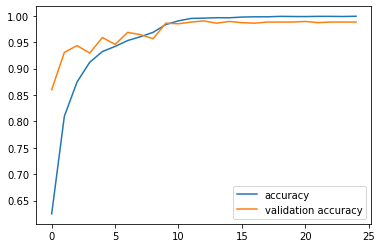

In [12]:
plt.plot(Brain_Tumor_obj.history.history['accuracy'], label = "accuracy")
plt.plot(Brain_Tumor_obj.history.history['val_accuracy'], label = "validation accuracy")
plt.legend()

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
Brain_Tumor_obj.m.save("drive/MyDrive/brain_tumor_model.h5")
Brain_Tumor_obj.m.save_weights("drive/MyDrive/brain_tumor_weights.h5")

In [15]:
Brain_Tumor_obj.m.evaluate(Brain_Tumor_obj.X_test, 
                           Brain_Tumor_obj.y_test, batch_size = 2)

460/460 [==============================] - 7s 15ms/step - loss: 0.0381 - accuracy: 0.9880


[0.03809912130236626, 0.988043487071991]

In [16]:
y_pred = Brain_Tumor_obj.m.predict(Brain_Tumor_obj.X_test)

In [18]:
y_pred = np.argmax(y_pred, axis = 1)

In [21]:
y_test = np.argmax(Brain_Tumor_obj.y_test, axis = 1)

In [23]:
from sklearn.metrics import accuracy_score as ac
ac(y_pred, y_test)

0.9880434782608696

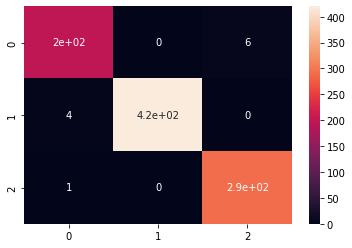

In [22]:
import seaborn as sns
sns.heatmap(tf.math.confusion_matrix(
    y_test,
    y_pred,
), annot=True)

#XGBOOST

In [10]:
m = tf.keras.models.load_model("drive/MyDrive/brain_tumor_model.h5")
m.load_weights("drive/MyDrive/brain_tumor_weights.h5")

In [11]:
new_model = tf.keras.models.Model(
    m.input,
    m.get_layer('GlobalAveragePooling2D_').output
)

In [12]:
X_train_features = new_model.predict(Brain_Tumor_obj.X_train)

In [13]:
X_train_features.shape

(8272, 1024)

In [14]:
from xgboost import XGBClassifier

In [30]:
xgb = XGBClassifier(objective='multiclass:softmax', learning_rate = 0.1,
              max_depth = 15, n_estimators = 500)
xgb.fit(X_train_features, np.argmax(Brain_Tumor_obj.y_train, axis = 1))

XGBClassifier(max_depth=15, n_estimators=500, objective='multi:softprob')

In [31]:
X_test_features = new_model.predict(Brain_Tumor_obj.X_test)

In [32]:
y_pred = xgb.predict(X_test_features)

In [33]:
y_test = np.argmax(Brain_Tumor_obj.y_test, axis =1)

In [35]:
from sklearn.metrics import accuracy_score as ac
ac(y_pred, y_test)

0.9902173913043478

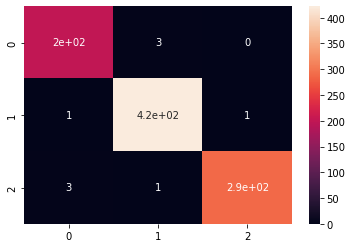

In [36]:
import seaborn as sns
sns.heatmap(tf.math.confusion_matrix(
    y_test,
    y_pred,
), annot=True)